# Advance Machine Learning - Assignment 1

This assignment focused on building and evaluating a deep learning model for handwritten letters classification using the EMNIST dataset. The implementation followed an **object-oriented programming (OOP) approach**, encapsulating dataset processing, model construction, and evaluation into modular components. I conducted `8` experiments by changing the model architecture and hyperparameters, the best model was from the `7th` experiment, where the number of neurons was the most influential factor. I used just `1 layer` with `512 neurons`.

### Approach and Findings
- The dataset was downloaded, analyzed, and preprocessed by flattening, normalizing inputs, and one-hot encoding labels.
- Neural networks was designed with multiple hidden layers, activation functions: `ReLU`, `GELU`, `Sigmoid`, `Tanh`, and `Adam` optimizer.
- Performance evaluation was conducted using `loss`, `accuracy`, `precision`, and `recall` metrics.
- Visualization techniques, including the confusion matrices and misclassified image analysis, provided insights into model performance.


### Interpretation of Model Learning
- The model successfully learned distinguishing features of handwritten letters by mapping pixel intensities to class labels.
- Accuracy improved significantly within the first few epochs, suggesting that the network effectively captured meaningful patterns.
- The most misclassified letters are: `i` and `j`, `q` and `g`, `i` and `l`.


### Uppercase vs Lowercase
- Uppercase letters are easier to classify than the lowercase, because it having more different structures in handwriting.
- Lowercase letters share similar handwritten patterns, such as `i` and `l`, while their uppercase counterparts, `I` and `L`, are more distinct.



### Changing The Batch Size

- Smaller batches give faster convergence in terms of iteration but can lead to more noise and instability in the optimization process.
- Larger batches more stable and can result in smoother convergence, but they may require more iterations to reach the optimal solution.

## Install and Import Dependencies

In [ ]:
!pip install tensorflow scipy pandas matplotlib seaborns numpy scikit-learn requests

In [ ]:
import os
import string
from dataclasses import dataclass, field
from zipfile import ZipFile
from scipy.io import loadmat
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import requests

## Construct the Dataset Skeleton and Its Utilities

In [ ]:
class Dataset:
  """
  Handles dataset downloading, loading, preprocessing and visualization.
  """
  def __init__(self, url, name, flatted=False, normalized=False, encoded=False, converted=False):
    """
    Initializes the dataset with metadata and processing flags.
    """
    self.url = url
    self.name = name
    self.flatted = flatted
    self.normalized = normalized
    self.encoded = encoded
    self.converted = converted
    self.path = os.path.join("/content/dataset/matlab", f"{self.name}.mat")
    self.classes = list(string.ascii_lowercase) if self.name == "emnist-letters" else []


  def download(self):
    """
    Downloads and extracts the dataset if not already available locally.
    """
    if os.path.exists(self.path):
      print(f"Dataset already exists locally at {self.path}")
      return

    os.makedirs("dataset", exist_ok=True)

    file_path = "matlab.zip"

    response = requests.get(self.url)

    with open(file_path, "wb") as file: file.write(response.content)

    with ZipFile(file_path, "r") as file: file.extractall("dataset")

    self.path = os.path.join("/content/dataset/matlab", f"{self.name}.mat")

    print(f"Dataset downloaded successfully and saved in {self.path}")


  def is_flatted(self, train_input, test_input):
    """
    Checks if the dataset is already flatted (2D representation).
    """
    self.flatted = True if train_input.ndim == 2 and test_input.ndim == 2 else False

    return self.flatted


  def is_gray(self, train_input, test_input):
    """
    Checks if the dataset is in grayscale format.
    """
    self.converted = True if train_input.shape[-1] == 28 * 28 and test_input.shape[-1] == 28 * 28 else False

    return self.converted


  def normalize(self, train_input, test_input):
    """
    Normalizes the dataset inputs to the range [0,1].
    """
    train_input, test_input = train_input / 255.0, test_input / 255.0

    self.normalized = True

    return train_input, test_input


  def one_hot(self, train_labels, test_labels):
    """
    Converts class labels into one-hot encoded format.
    """
    train_labels, test_labels = train_labels - 1, test_labels - 1

    num_classes = np.unique(train_labels).shape[0]

    train_labels, test_labels = to_categorical(train_labels, num_classes=num_classes), to_categorical(test_labels, num_classes=num_classes)

    self.encoded = True

    return train_labels, test_labels


  def load(self):
    """
    Loads and preprocesses the dataset, applying normalization and encoding if specified.
    """
    self.download() if not os.path.exists(self.path) else None

    emnist = loadmat(self.path)

    train_input, test_input = emnist["dataset"][0][0][0][0][0][0].astype(np.float32), emnist["dataset"][0][0][1][0][0][0].astype(np.float32)
    train_labels, test_labels = emnist["dataset"][0][0][0][0][0][1].flatten(), emnist["dataset"][0][0][1][0][0][1].flatten()

    train_input, test_input = self.normalize(train_input, test_input) if self.normalized else (train_input, test_input)
    train_labels, test_labels = self.one_hot(train_labels, test_labels) if self.encoded else (train_labels, test_labels)

    return train_input, test_input, train_labels, test_labels


  def info(self):
    """
    Displays dataset information, including shape, encoding, and preprocessing status.
    """
    print("-" * 50)

    train_input, test_input, train_labels, test_labels = self.load()

    information = {"Flatted": self.is_flatted(train_input, test_input),
                   "Grayscale": self.is_gray(train_input, test_input),
                   "Normalized": self.normalized,
                   "Encoded": self.encoded,
                   "Training Size": train_input.shape,
                   "Testing Size": test_input.shape,
                   "Training Labels": train_labels.shape,
                   "Testing Labels": test_labels.shape,
                   "Number of Classes": len(self.classes)}

    print (pd.Series(information))

    print("-" * 50)


  def visualize(self, inputs, target):
    """
    Visualizes a sample of the dataset images with their corresponding labels.
    """
    reshaped = inputs.reshape(inputs.shape[0], 28, 28, order="A")

    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.grid(False)
        plt.imshow(reshaped[i], cmap="gray")
        plt.xlabel(self.classes[np.argmax(target[i])])

    plt.show()

### Download the dataset and display its information

In [ ]:
dataset = Dataset(url="https://biometrics.nist.gov/cs_links/EMNIST/matlab.zip", name="emnist-letters")

dataset.download()

dataset.info()

Dataset downloaded successfully and saved in /content/dataset/matlab/emnist-letters.mat
--------------------------------------------------
Flatted                       True
Grayscale                     True
Normalized                   False
Encoded                      False
Training Size        (124800, 784)
Testing Size          (20800, 784)
Training Labels          (124800,)
Testing Labels            (20800,)
Number of Classes               26
dtype: object
--------------------------------------------------


### Load the dataset, normalize the inputs and apply one-hot encoding to the labels

In [ ]:
train_input, test_input, train_labels, test_labels = dataset.load()

train_input, test_input = dataset.normalize(train_input, test_input)

train_labels, test_labels = dataset.one_hot(train_labels, test_labels)

dataset.info()

--------------------------------------------------
Flatted                       True
Grayscale                     True
Normalized                    True
Encoded                       True
Training Size        (124800, 784)
Testing Size          (20800, 784)
Training Labels       (124800, 26)
Testing Labels         (20800, 26)
Number of Classes               26
dtype: object
--------------------------------------------------


### Display a few samples of the dataset

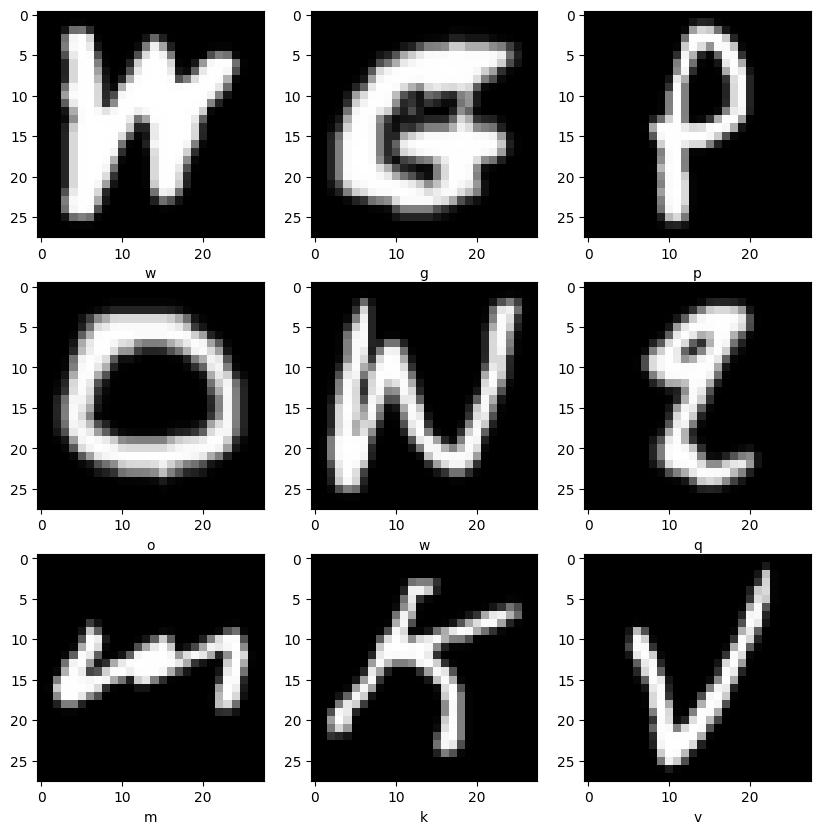

In [ ]:
dataset.visualize(train_input, train_labels)

## Setup Model Configurations and Hyperparameters

### Define the `learning rate scheduler` and `early stopping` callbacks

In [ ]:
def lr_schedule(epoch):
    """
    Adjusts the learning rate based on the epoch number using exponential decay.
    """
    initial_lr = 0.001

    decay_factor = 0.1

    decay_epochs = 5

    return initial_lr * (decay_factor ** (epoch // decay_epochs))


early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

### Construct the model configurations skeleton

In [ ]:
@dataclass
class Config:
    """
    Stores hyperparameters and dataset configurations for training the models.
    """
    input_shape: tuple = field(default_factory=lambda: (train_input.shape[1],))
    hidden_layers: int = 2
    hidden_neurons: list = field(default_factory=lambda: [128, 64])
    hidden_activations: list = field(default_factory=lambda: ["relu", "relu"])
    output_neurons: int = field(default_factory=lambda: train_labels.shape[1])
    output_activation: str = "softmax"
    optimizer: str = "adam"
    loss: str = "categorical_crossentropy"
    metrics: list = field(default_factory=lambda: ["accuracy", "recall", "precision"])
    train_input: np.ndarray = field(default_factory=lambda: train_input)
    train_labels: np.ndarray = field(default_factory=lambda: train_labels)
    test_input: np.ndarray = field(default_factory=lambda: test_input)
    test_labels: np.ndarray = field(default_factory=lambda: test_labels)
    epochs: int = 30
    batch_size: int = 32
    validation_split: float | None = 0.2
    validation_data: tuple | None = None
    callbacks: list | None = field(default_factory=lambda: [early_stopping, lr_scheduler])
    input_flatted: bool = True

## Construct the Model Skeleton and Its Utilities

In [ ]:
class Model:
    """
    Defines and manages a neural network model, including building, compiling, training, evaluation, and visualization.
    """
    def __init__(self, config: Config):
      """
      Initializes the model with the given configuration.
      """
      self.config = config
      self.model = models.Sequential()

      assert config.hidden_layers == len(config.hidden_neurons) == len(config.hidden_activations), "hidden_layers must match hidden_neurons and hidden_activations lengths."


    def build(self):
      """
      Constructs the neural network architecture based on the configuration.
      """
      self.model = models.Sequential()

      self.model.add(layers.Flatten(input_shape=self.config.input_shape)) if not self.config.input_flatted else self.model.add(layers.Input(shape=self.config.input_shape, batch_size=self.config.batch_size))

      for index in range(self.config.hidden_layers):
          self.model.add(layers.Dense(units=self.config.hidden_neurons[index], activation=self.config.hidden_activations[index]))

      self.model.add(layers.Dense(units=self.config.output_neurons, activation=self.config.output_activation))

      return self.model


    def summary(self):
      """
      Displays the model architecture summary.
      """
      self.model.summary()


    def compile(self):
      """
      Compiles the model with the specified optimizer, loss function, and metrics.
      """
      self.model.compile(optimizer=self.config.optimizer, loss=self.config.loss, metrics=self.config.metrics)


    def train(self):
      """
      Trains the model using the provided dataset and returns the training history.
      """
      return self.model.fit(x=self.config.train_input, y=self.config.train_labels,
                            epochs=self.config.epochs, batch_size=self.config.batch_size,
                            validation_split=self.config.validation_split,
                            validation_data=self.config.validation_data,
                            callbacks=self.config.callbacks)


    def evaluate(self):
      """
      Evaluates the model on the test dataset and returns performance metrics.
      """
      return self.model.evaluate(x=self.config.test_input, y=self.config.test_labels)


    def predict(self, inputs):
      """
      Generates predictions for the given input data.
      """
      return self.model.predict(inputs)


    def visualize(self, history, metric):
      """
      Plots the training and validation performance over epochs for a given metric.
      """
      plt.plot(history.history[metric], label=f"Training {metric}", color="blue", linestyle="-", linewidth=2)
      plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}", color="red", linestyle="--", linewidth=2)
      plt.xlabel("Epochs")
      plt.ylabel(metric.capitalize())
      plt.legend()
      plt.grid(True, linestyle="--", alpha=0.7)
      plt.title(f"{metric.capitalize()} Over Epochs")
      plt.tight_layout()
      plt.show()


    def visualize_misclassified_images(self, classes):
      """
      Displays a set of misclassified images along with their predicted and actual labels.
      """
      predicted_labels = np.argmax(self.model.predict(self.config.test_input), axis=1)

      actual_labels = np.argmax(self.config.test_labels, axis=1)

      misclassified = np.random.choice(np.where(predicted_labels != actual_labels)[0], 9, replace=False)

      reshaped_images = self.config.test_input.reshape(-1, 28, 28, order="A")

      plt.figure(figsize=(10, 10))

      for i, idx in enumerate(misclassified):
          plt.subplot(3, 3, i + 1)
          plt.imshow(reshaped_images[idx], cmap="gray")
          actual = classes[actual_labels[idx]]
          predicted = classes[predicted_labels[idx]]
          plt.title(f"Actual: {actual}\nPredicted: {predicted}", fontsize=10, color="red")
          plt.axis("off")

      plt.tight_layout()
      plt.show()


    def display_confusion_matrix(self, classes):
      """
      Plots a confusion matrix to analyze model performance.
      """
      predicted = np.argmax(self.model.predict(self.config.test_input), axis=1)
      actual = np.argmax(self.config.test_labels, axis=1)

      cm = confusion_matrix(actual, predicted)

      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=classes, yticklabels=classes)

      plt.xlabel("Predicted Label")
      plt.ylabel("True Label")
      plt.title("Confusion Matrix")
      plt.tight_layout()
      plt.show()


    def cross_validate(self, k=5, with_plot=False):
      """
      Performs k-fold cross-validation and returns the average validation loss and accuracy.

      Plot the validation loss and accuracy for each fold if `with_plot` is True.
      """
      kf = KFold(n_splits=k, shuffle=True, random_state=42)
      val_losses = []
      val_accuracies = []

      train_input = np.array(self.config.train_input)
      train_labels = np.array(self.config.train_labels)

      for fold, (train_idx, val_idx) in enumerate(kf.split(train_input)):
        print(f"Training fold {fold + 1}/{k}...")

        x_train, x_val = train_input[train_idx], train_input[val_idx]
        y_train, y_val = train_labels[train_idx], train_labels[val_idx]

        self.config.train_input = x_train
        self.config.train_labels = y_train
        self.config.validation_data = (x_val, y_val)
        self.config.validation_split = None

        self.model = self.build()
        self.compile()

        history = self.train()

        evaluation_results = self.model.evaluate(x_val, y_val)

        val_loss = evaluation_results[0]
        val_accuracy = evaluation_results[1]

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if with_plot:
          self.visualize(history, "loss")

        print("-" * 50)
        print(f"Loss: {np.mean(val_losses):.4f}")
        print(f"Accuracy: {np.mean(val_accuracies):.4f}")
        print("-" * 50)

      return np.mean(val_losses), np.mean(val_accuracies)

### **Experiment-1**

### Initialize the model and display its architecture

In [ ]:
config = Config()

model = Model(config=config)

model.build()

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (32, 128)                   │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 26)                    │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,426 (431.35 KB)

 Trainable params: 110,426 (431.35 KB)

 Non-trainable params: 0 (0.00 B)

### Start the model training loop

In [ ]:
model.compile()

history = model.train()

Epoch 1/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6748 - loss: 1.1230 - precision: 0.8344 - recall: 0.5395 - val_accuracy: 0.8499 - val_loss: 0.4934 - val_precision: 0.8893 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 2/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8638 - loss: 0.4344 - precision: 0.8978 - recall: 0.8351 - val_accuracy: 0.8752 - val_loss: 0.4021 - val_precision: 0.9042 - val_recall: 0.8529 - learning_rate: 0.0010
Epoch 3/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8897 - loss: 0.3441 - precision: 0.9118 - recall: 0.8705 - val_accuracy: 0.8744 - val_loss: 0.4063 - val_precision: 0.8983 - val_recall: 0.8547 - learning_rate: 0.0010
Epoch 4/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8996 - loss: 0.3055 - precision: 0.9182 - recall: 0.8840 - val_accuracy: 0.8817 - val_loss: 0.3770 - val_precision: 0.9030 - val_recall: 0.8660 - learning_rate: 0.0010
Epoch 5/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/st

### Visualize the training and validation `loss`

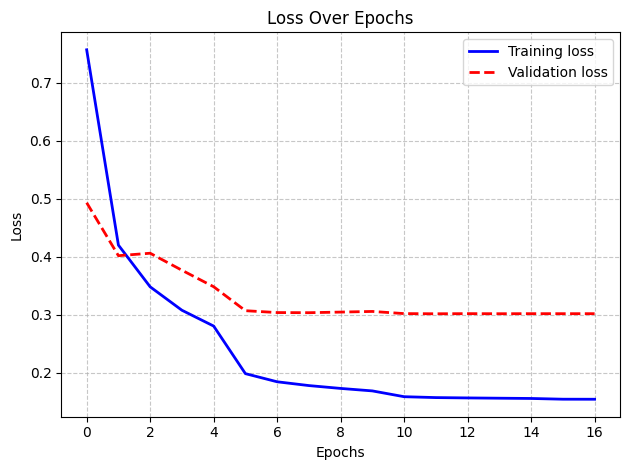

In [ ]:
model.visualize(history, "loss")

### Visualize the training and validation `accuracy`

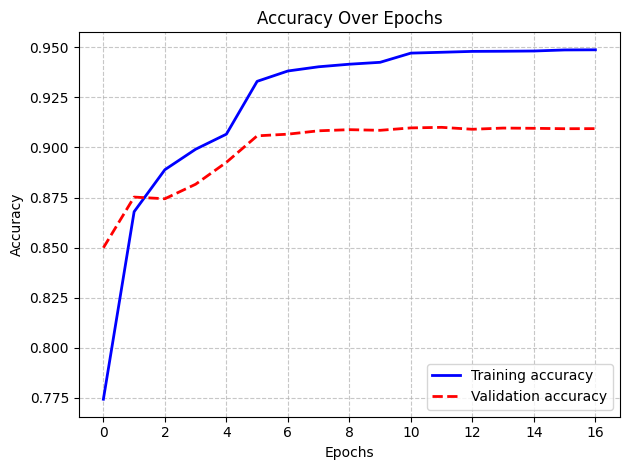

In [ ]:
model.visualize(history, "accuracy")

### Visualize the training and validation `recall`

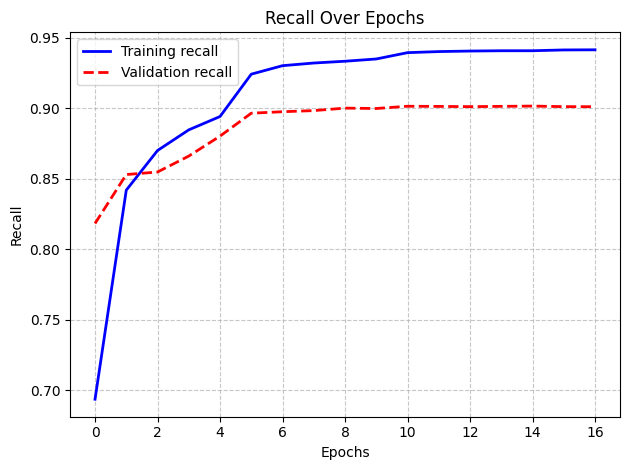

In [ ]:
model.visualize(history, "recall")

### Visualize the training and validation `precision`

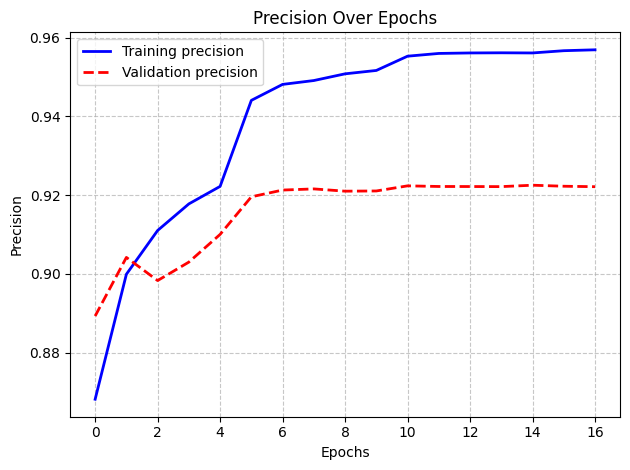

In [ ]:
model.visualize(history, "precision")

### Evaluate the model on the test set

In [ ]:
test_loss, test_accuracy, test_recall, test_precision = model.evaluate()
print("-" * 110)
print(f"Loss: {test_loss:.2f}")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {test_precision:.2f}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9000 - loss: 0.3365 - precision: 0.9139 - recall: 0.8912
--------------------------------------------------------------------------------------------------------------
Loss: 0.31
Accuracy: 0.91
Recall: 0.90
Precision: 0.92


### Display the `confusion matrix` and identify common misclassifications

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


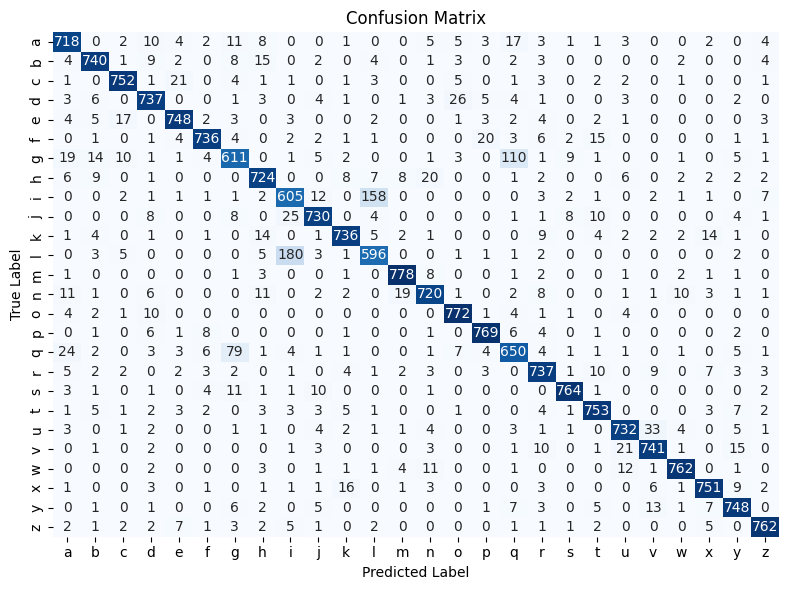

In [ ]:
model.display_confusion_matrix(classes=dataset.classes)

### Visualize the misclassified images

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


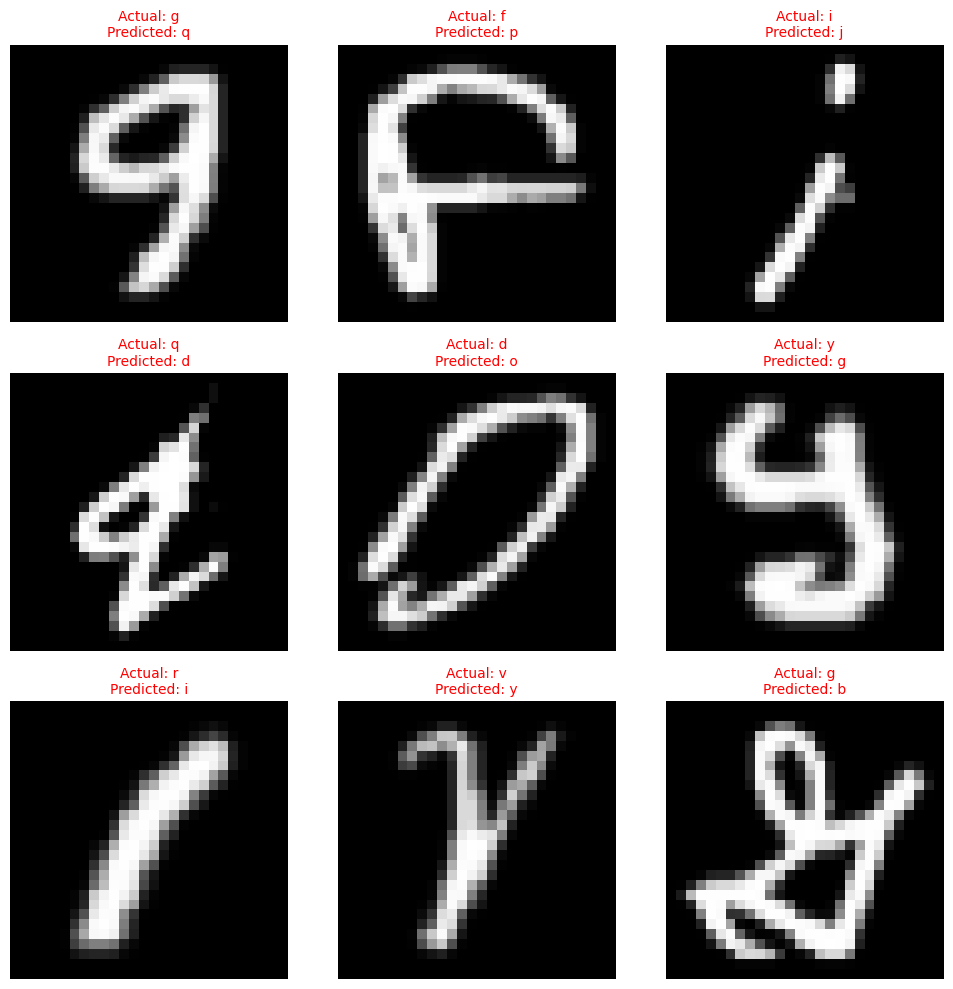

In [ ]:
model.visualize_misclassified_images(classes=dataset.classes)

### Perform model predictions on the test set

In [ ]:
predictions = model.predict(test_input)

predicted_labels = np.argmax(predictions, axis=1)

actual_labels = np.argmax(test_labels, axis=1)

650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


### Visualizing model predictions on randomly selected test images

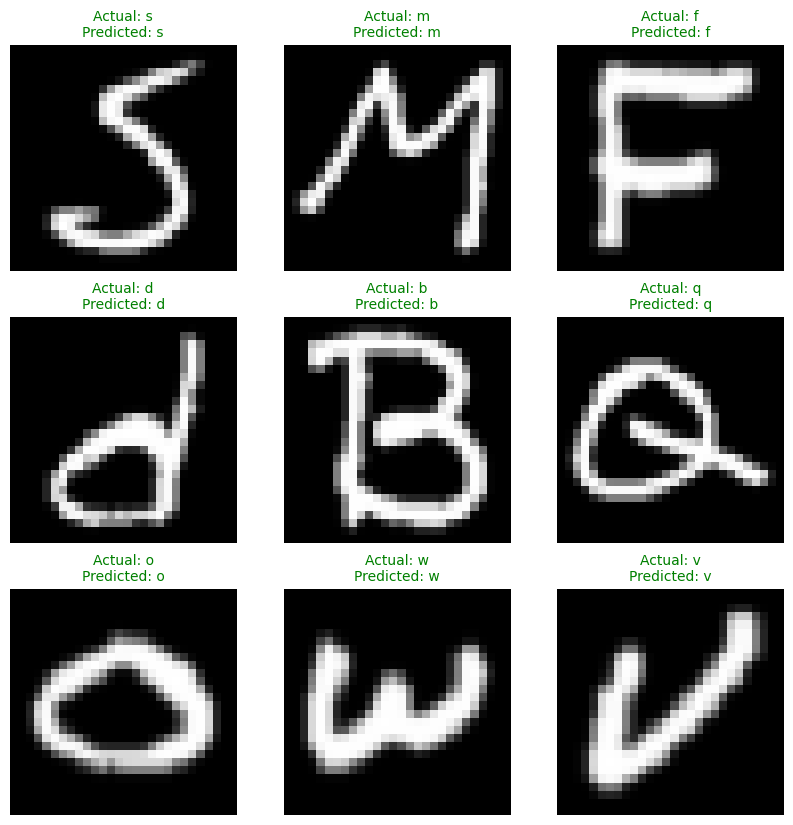

In [ ]:
indices = np.random.choice(test_input.shape[0], 9, replace=False)

reshaped_images = test_input.reshape(-1, 28, 28, order="A")

plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(reshaped_images[idx], cmap="gray")

    actual = dataset.classes[actual_labels[idx]]
    predicted = dataset.classes[predicted_labels[idx]]

    plt.title(f"Actual: {actual}\nPredicted: {predicted}", fontsize=10, color="green" if actual == predicted else "red")
    plt.axis("off")

plt.show()

### Comparing performance across different folds

Training fold 1/5...
Epoch 1/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6781 - loss: 1.1079 - precision: 0.8406 - recall: 0.5477 - val_accuracy: 0.8500 - val_loss: 0.4875 - val_precision: 0.8930 - val_recall: 0.8109 - learning_rate: 0.0010
Epoch 2/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8610 - loss: 0.4458 - precision: 0.8958 - recall: 0.8303 - val_accuracy: 0.8716 - val_loss: 0.4046 - val_precision: 0.8999 - val_recall: 0.8477 - learning_rate: 0.0010
Epoch 3/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8889 - loss: 0.3457 - precision: 0.9119 - recall: 0.8701 - val_accuracy: 0.8777 - val_loss: 0.3863 - val_precision: 0.9027 - val_recall: 0.8599 - learning_rate: 0.0010
Epoch 4/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9016 - loss: 0.3012 - precision: 0.9202 - recall: 0.8858 - val_accuracy: 0.8893 - val_loss: 0.3560 - val_precision: 0.9092 - val_recall: 0.8759 - learning_rate: 0.0010
Epoch 5/30
3120/3120 ━━━━━━━━━━

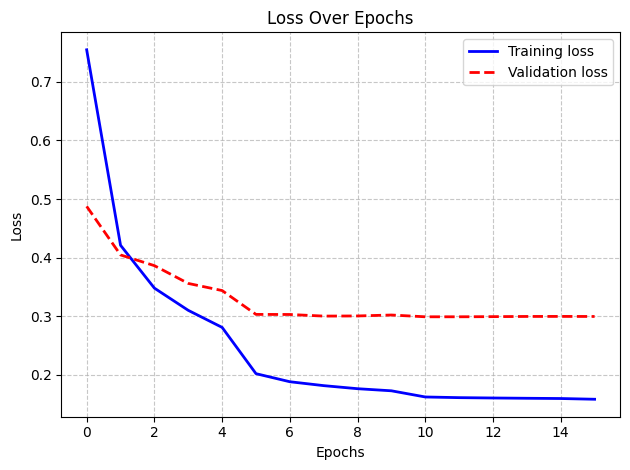

--------------------------------------------------
Loss: 0.2990
Accuracy: 0.9083
--------------------------------------------------
Training fold 2/5...
Epoch 1/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6746 - loss: 1.1207 - precision: 0.8411 - recall: 0.5412 - val_accuracy: 0.8479 - val_loss: 0.4944 - val_precision: 0.8909 - val_recall: 0.8093 - learning_rate: 0.0010
Epoch 2/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8622 - loss: 0.4411 - precision: 0.8974 - recall: 0.8306 - val_accuracy: 0.8680 - val_loss: 0.4343 - val_precision: 0.8964 - val_recall: 0.8451 - learning_rate: 0.0010
Epoch 3/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8882 - loss: 0.3468 - precision: 0.9122 - recall: 0.8683 - val_accuracy: 0.8800 - val_loss: 0.3877 - val_precision: 0.9010 - val_recall: 0.8651 - learning_rate: 0.0010
Epoch 4/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9023 - loss: 0.3054 - precision: 0.9204 - recall: 0.8870 - val_accu

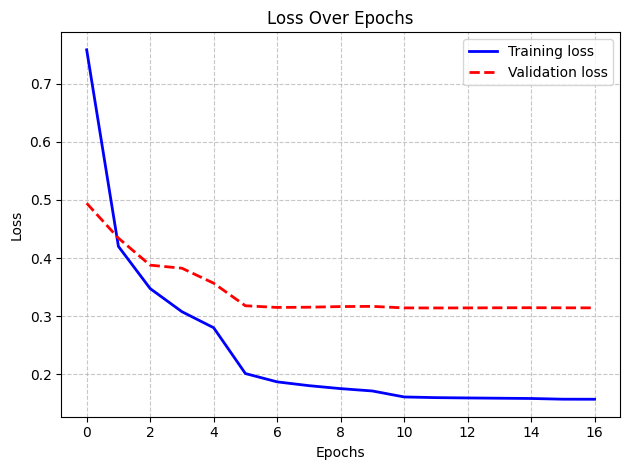

--------------------------------------------------
Loss: 0.3065
Accuracy: 0.9065
--------------------------------------------------
Training fold 3/5...
Epoch 1/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6725 - loss: 1.1300 - precision: 0.8418 - recall: 0.5390 - val_accuracy: 0.8409 - val_loss: 0.5167 - val_precision: 0.8791 - val_recall: 0.8093 - learning_rate: 0.0010
Epoch 2/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8647 - loss: 0.4295 - precision: 0.9005 - recall: 0.8368 - val_accuracy: 0.8702 - val_loss: 0.4151 - val_precision: 0.8990 - val_recall: 0.8453 - learning_rate: 0.0010
Epoch 3/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8868 - loss: 0.3518 - precision: 0.9110 - recall: 0.8662 - val_accuracy: 0.8791 - val_loss: 0.3859 - val_precision: 0.9012 - val_recall: 0.8617 - learning_rate: 0.0010
Epoch 4/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9001 - loss: 0.3084 - precision: 0.9184 - recall: 0.8836 - val_accu

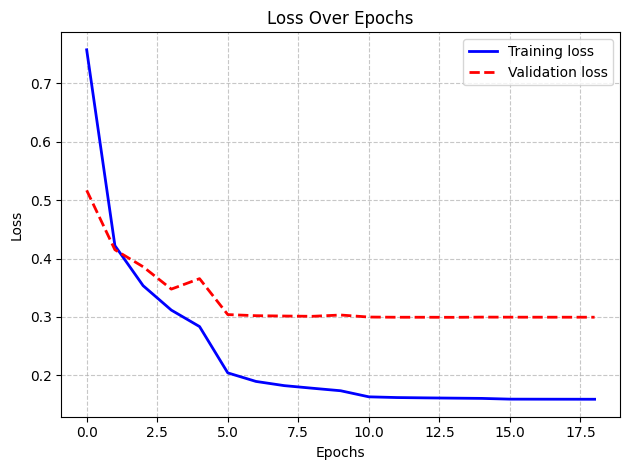

--------------------------------------------------
Loss: 0.3042
Accuracy: 0.9072
--------------------------------------------------
Training fold 4/5...
Epoch 1/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6746 - loss: 1.1109 - precision: 0.8410 - recall: 0.5448 - val_accuracy: 0.8516 - val_loss: 0.4745 - val_precision: 0.8931 - val_recall: 0.8157 - learning_rate: 0.0010
Epoch 2/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8637 - loss: 0.4308 - precision: 0.8975 - recall: 0.8343 - val_accuracy: 0.8710 - val_loss: 0.4052 - val_precision: 0.8992 - val_recall: 0.8481 - learning_rate: 0.0010
Epoch 3/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.8867 - loss: 0.3540 - precision: 0.9101 - recall: 0.8670 - val_accuracy: 0.8786 - val_loss: 0.3925 - val_precision: 0.9009 - val_recall: 0.8591 - learning_rate: 0.0010
Epoch 4/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8988 - loss: 0.3077 - precision: 0.9182 - recall: 0.8839 - val_accu

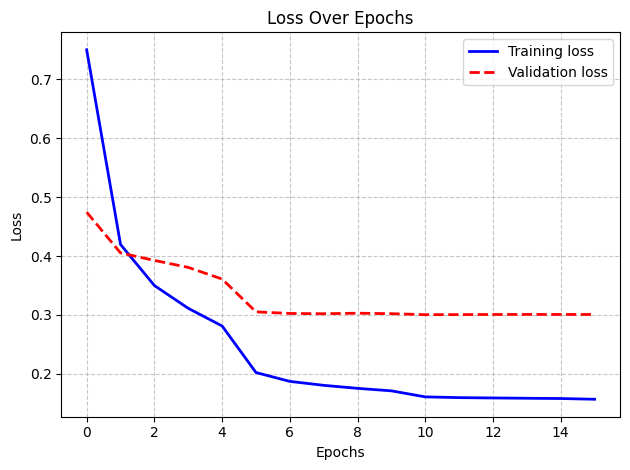

--------------------------------------------------
Loss: 0.3032
Accuracy: 0.9071
--------------------------------------------------
Training fold 5/5...
Epoch 1/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6752 - loss: 1.1139 - precision: 0.8427 - recall: 0.5453 - val_accuracy: 0.8453 - val_loss: 0.4933 - val_precision: 0.8845 - val_recall: 0.8112 - learning_rate: 0.0010
Epoch 2/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8627 - loss: 0.4408 - precision: 0.8966 - recall: 0.8319 - val_accuracy: 0.8756 - val_loss: 0.4006 - val_precision: 0.9029 - val_recall: 0.8525 - learning_rate: 0.0010
Epoch 3/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8868 - loss: 0.3516 - precision: 0.9110 - recall: 0.8670 - val_accuracy: 0.8810 - val_loss: 0.3724 - val_precision: 0.9033 - val_recall: 0.8645 - learning_rate: 0.0010
Epoch 4/30
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8985 - loss: 0.3068 - precision: 0.9182 - recall: 0.8836 - val_accu

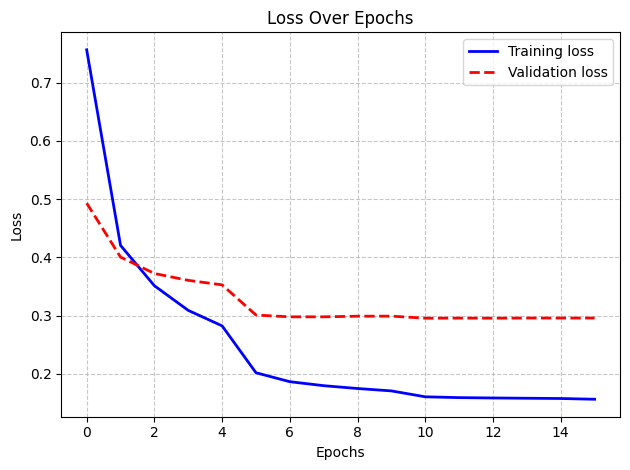

--------------------------------------------------
Loss: 0.3017
Accuracy: 0.9074
--------------------------------------------------


In [ ]:
validation_loss, validation_accuracy = model.cross_validate(k=5, with_plot=True)

### Visualize the first hidden layer weights

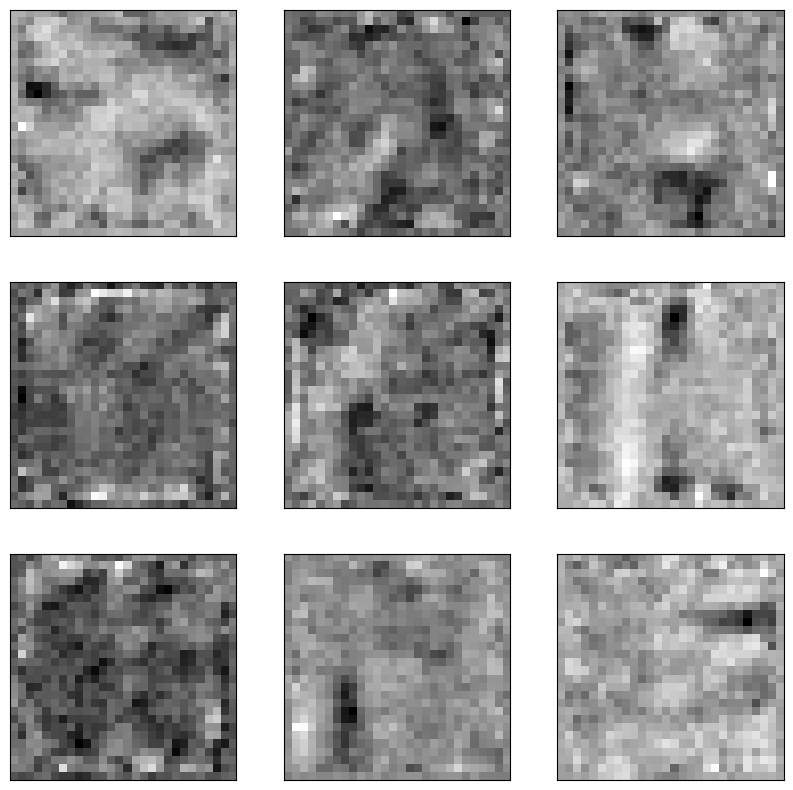

In [ ]:
weights, biases = model.model.layers[0].get_weights()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    neuron_weights = weights[:, i].reshape(28, 28, order="A")

    plt.imshow(neuron_weights, cmap="gray")

plt.show()

## Experimenting with changes in model architecture

### **Experiment-2**

- `epochs`: 15
- `batch size`: 16
- `hidden layers`: 4
- `hidden neurons`: 128, 64, 32, 16
- `hidden activations`: GELU

In [ ]:
config.epochs = 15
config.batch_size = 16
config.hidden_layers = 4
config.hidden_neurons = [128, 64, 32, 16]
config.hidden_activations = ["gelu", "gelu", "gelu", "gelu"]

model = Model(config=config)

model.build()

model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                     │ (16, 128)                   │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (16, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (16, 32)                    │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (16, 16)                    │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (16, 26)                    │             442 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,786 (436.66 KB)

 Trainable params: 111,786 (436.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile()

history = model.train()

Epoch 1/15
6240/6240 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.6559 - loss: 1.1707 - precision: 0.8273 - recall: 0.5405 - val_accuracy: 0.8431 - val_loss: 0.5029 - val_precision: 0.8802 - val_recall: 0.8133 - learning_rate: 0.0010
Epoch 2/15
6240/6240 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.8583 - loss: 0.4511 - precision: 0.8930 - recall: 0.8301 - val_accuracy: 0.8609 - val_loss: 0.4370 - val_precision: 0.8855 - val_recall: 0.8416 - learning_rate: 0.0010
Epoch 3/15
6240/6240 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8826 - loss: 0.3637 - precision: 0.9077 - recall: 0.8641 - val_accuracy: 0.8772 - val_loss: 0.3920 - val_precision: 0.9006 - val_recall: 0.8620 - learning_rate: 0.0010
Epoch 4/15
6240/6240 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.8934 - loss: 0.3249 - precision: 0.9136 - recall: 0.8768 - val_accuracy: 0.8814 - val_loss: 0.3774 - val_precision: 0.9007 - val_recall: 0.8648 - learning_rate: 0.0010
Epoch 5/15
6240/6240 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/st

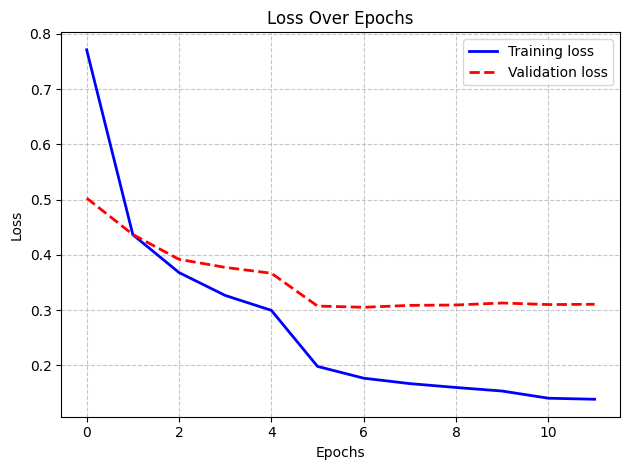

In [ ]:
model.visualize(history, "loss")

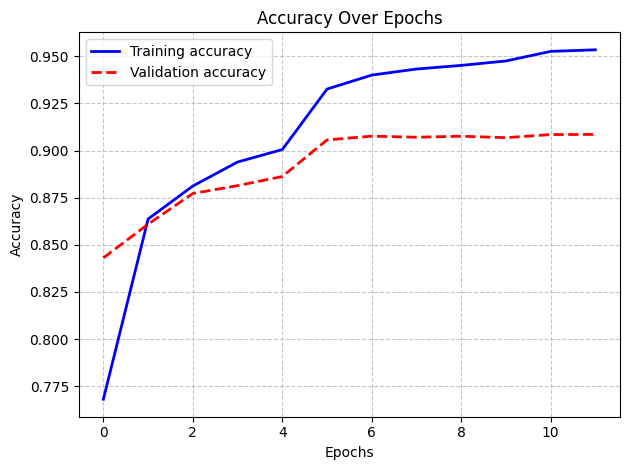

In [ ]:
model.visualize(history, "accuracy")

In [ ]:
test_loss, test_accuracy, test_recall, test_precision = model.evaluate()
print("-" * 110)
print(f"Loss: {test_loss:.2f}")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {test_precision:.2f}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8992 - loss: 0.3401 - precision: 0.9126 - recall: 0.8914
--------------------------------------------------------------------------------------------------------------
Loss: 0.32
Accuracy: 0.91
Recall: 0.90
Precision: 0.92


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


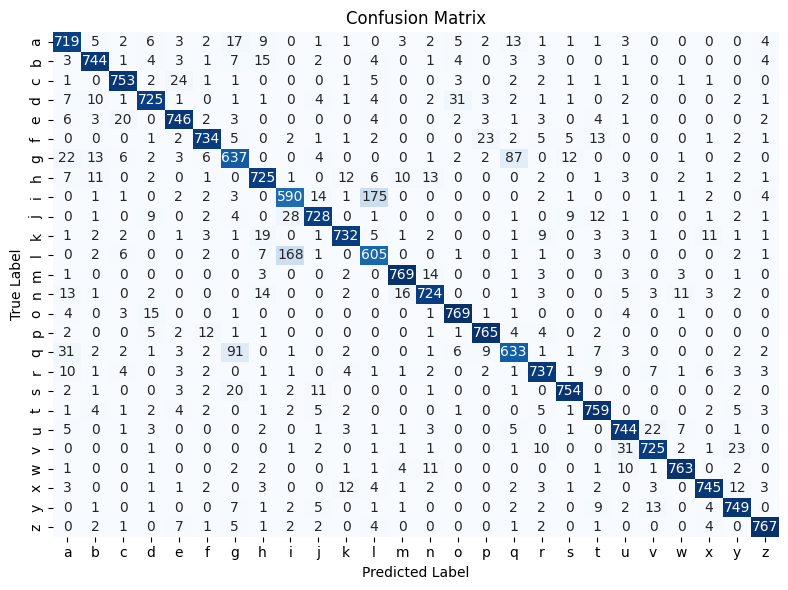

In [ ]:
model.display_confusion_matrix(classes=dataset.classes)

### **Experiment-3**

- `epochs`: 20
- `batch size`: 64
- `hidden layers`: 5
- `hidden neurons`: 256, 256, 128, 256, 128
- `hidden activations`: ReLU

In [ ]:
config.epochs = 20
config.batch_size = 64
config.hidden_layers = 5
config.hidden_neurons = [256, 256, 128, 256, 128]
config.hidden_activations = ["relu", "relu", "relu", "relu", "relu"]

model = Model(config=config)

model.build()

model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                     │ (64, 256)                   │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (64, 256)                   │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (64, 128)                   │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (64, 256)                   │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (64, 128)                   │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (64, 26)                    │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 368,922 (1.41 MB)

 Trainable params: 368,922 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile()

history = model.train()

Epoch 1/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6764 - loss: 1.0677 - precision: 0.8206 - recall: 0.5754 - val_accuracy: 0.8607 - val_loss: 0.4402 - val_precision: 0.8909 - val_recall: 0.8358 - learning_rate: 0.0010
Epoch 2/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8767 - loss: 0.3729 - precision: 0.9039 - recall: 0.8558 - val_accuracy: 0.8861 - val_loss: 0.3478 - val_precision: 0.9087 - val_recall: 0.8685 - learning_rate: 0.0010
Epoch 3/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9006 - loss: 0.2963 - precision: 0.9197 - recall: 0.8856 - val_accuracy: 0.8903 - val_loss: 0.3397 - val_precision: 0.9095 - val_recall: 0.8756 - learning_rate: 0.0010
Epoch 4/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9141 - loss: 0.2521 - precision: 0.9284 - recall: 0.9017 - val_accuracy: 0.8946 - val_loss: 0.3300 - val_precision: 0.9124 - val_recall: 0.8802 - learning_rate: 0.0010
Epoch 5/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/s

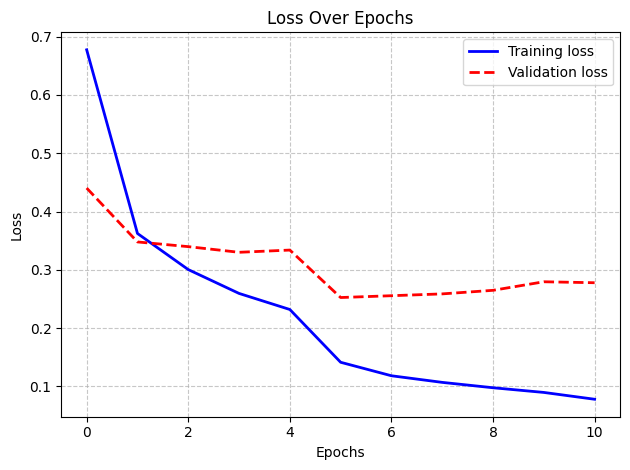

In [ ]:
model.visualize(history, "loss")

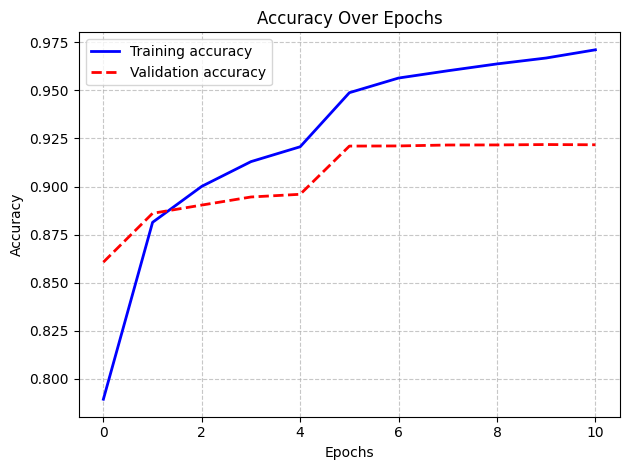

In [ ]:
model.visualize(history, "accuracy")

In [ ]:
test_loss, test_accuracy, test_recall, test_precision = model.evaluate()
print("-" * 110)
print(f"Loss: {test_loss:.2f}")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {test_precision:.2f}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9119 - loss: 0.2905 - precision: 0.9230 - recall: 0.9059
--------------------------------------------------------------------------------------------------------------
Loss: 0.27
Accuracy: 0.92
Recall: 0.91
Precision: 0.93


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


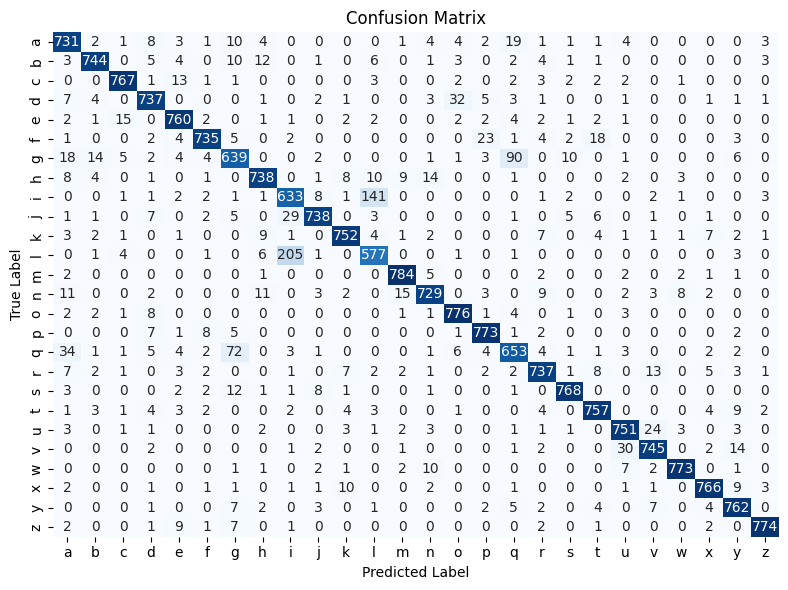

In [ ]:
model.display_confusion_matrix(classes=dataset.classes)

### **Experiment-4**

- `epochs`: 10
- `batch size`: 128
- `hidden layers`: 2
- `hidden neurons`: 512, 512
- `hidden activations`: ReLU

In [ ]:
config.epochs = 10
config.batch_size = 128
config.hidden_layers = 2
config.hidden_neurons = [512, 512]
config.hidden_activations = ["relu", "relu"]

model = Model(config=config)

model.build()

model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                     │ (128, 512)                  │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (128, 512)                  │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (128, 26)                   │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 677,914 (2.59 MB)

 Trainable params: 677,914 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile()

history = model.train()

Epoch 1/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.7124 - loss: 0.9848 - precision: 0.8473 - recall: 0.6006 - val_accuracy: 0.8756 - val_loss: 0.3962 - val_precision: 0.9031 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 2/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8922 - loss: 0.3327 - precision: 0.9155 - recall: 0.8704 - val_accuracy: 0.8959 - val_loss: 0.3208 - val_precision: 0.9151 - val_recall: 0.8815 - learning_rate: 0.0010
Epoch 3/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9167 - loss: 0.2471 - precision: 0.9316 - recall: 0.9031 - val_accuracy: 0.9027 - val_loss: 0.2994 - val_precision: 0.9190 - val_recall: 0.8923 - learning_rate: 0.0010
Epoch 4/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9314 - loss: 0.2005 - precision: 0.9414 - recall: 0.9219 - val_accuracy: 0.9080 - val_loss: 0.2834 - val_precision: 0.9201 - val_recall: 0.8996 - learning_rate: 0.0010
Epoch 5/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - 

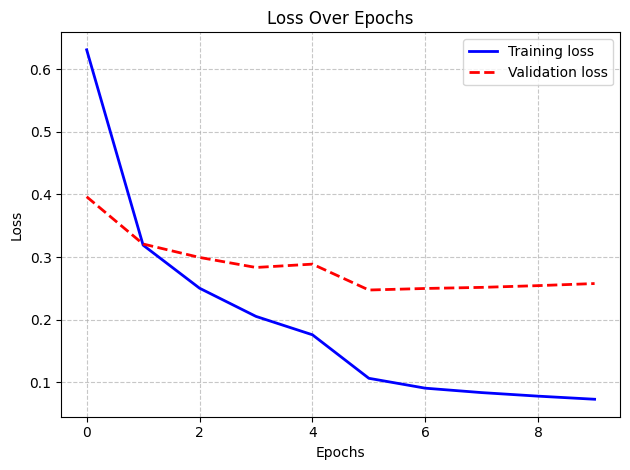

In [ ]:
model.visualize(history, "loss")

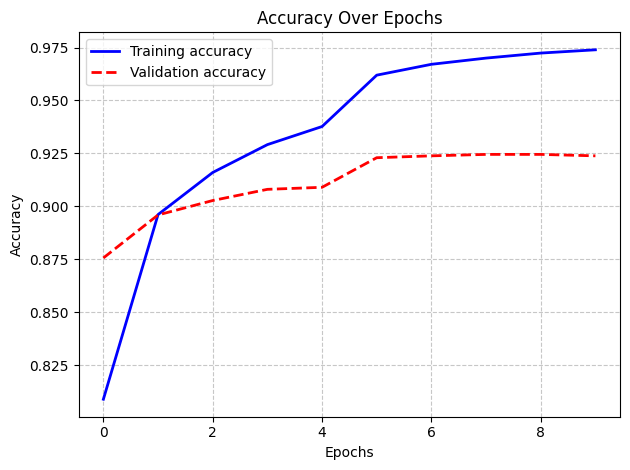

In [ ]:
model.visualize(history, "accuracy")

In [ ]:
test_loss, test_accuracy, test_recall, test_precision = model.evaluate()
print("-" * 110)
print(f"Loss: {test_loss:.2f}")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {test_precision:.2f}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9170 - loss: 0.2678 - precision: 0.9249 - recall: 0.9117
--------------------------------------------------------------------------------------------------------------
Loss: 0.25
Accuracy: 0.92
Recall: 0.92
Precision: 0.93


650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


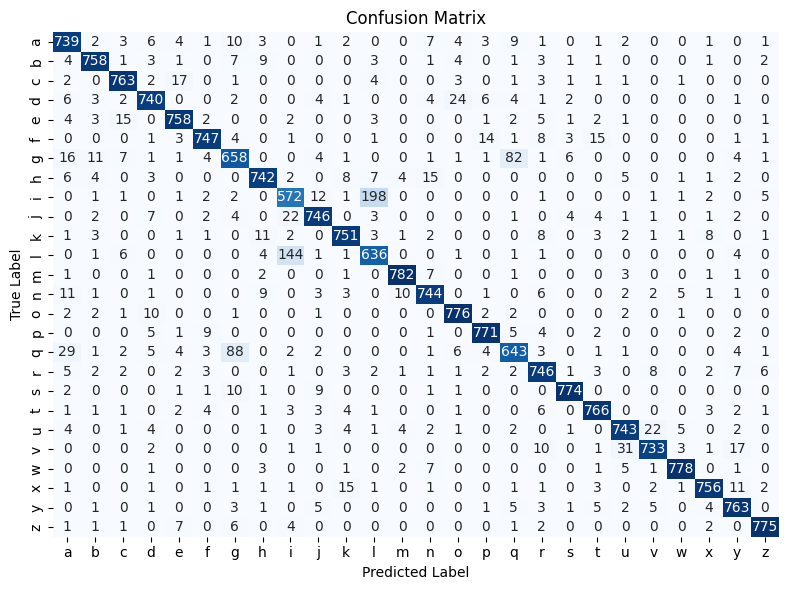

In [ ]:
model.display_confusion_matrix(classes=dataset.classes)

### **Experiment-5**

- `epochs`: 10
- `batch size`: 8
- `hidden layers`: 1
- `hidden neurons`: 128
- `hidden activations`: Sigmoid

In [ ]:
config.epochs = 10
config.batch_size = 8
config.hidden_layers = 1
config.hidden_neurons = [128]
config.hidden_activations = ["sigmoid"]

model = Model(config=config)

model.build()

model.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_83 (Dense)                     │ (8, 128)                    │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (8, 26)                     │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,834 (405.60 KB)

 Trainable params: 103,834 (405.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile()

history = model.train()

Epoch 1/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6529 - loss: 1.2596 - precision: 0.8727 - recall: 0.4410 - val_accuracy: 0.8267 - val_loss: 0.5847 - val_precision: 0.8920 - val_recall: 0.7680 - learning_rate: 0.0010
Epoch 2/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - accuracy: 0.8460 - loss: 0.5208 - precision: 0.9037 - recall: 0.7926 - val_accuracy: 0.8578 - val_loss: 0.4674 - val_precision: 0.9004 - val_recall: 0.8200 - learning_rate: 0.0010
Epoch 3/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.8758 - loss: 0.4087 - precision: 0.9142 - recall: 0.8396 - val_accuracy: 0.8708 - val_loss: 0.4171 - val_precision: 0.9056 - val_recall: 0.8414 - learning_rate: 0.0010
Epoch 4/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.8899 - loss: 0.3539 - precision: 0.9199 - recall: 0.8645 - val_accuracy: 0.8730 - val_loss: 0.4059 - val_precision: 0.9026 - val_recall: 0.8481 - learning_rate: 0.0010
Epoch 5/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 

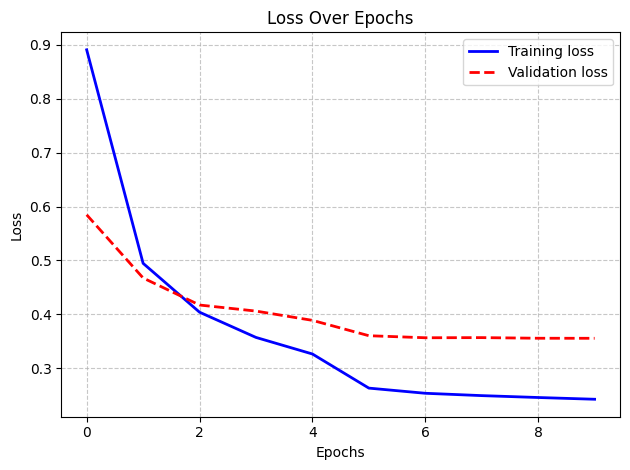

In [ ]:
model.visualize(history, "loss")

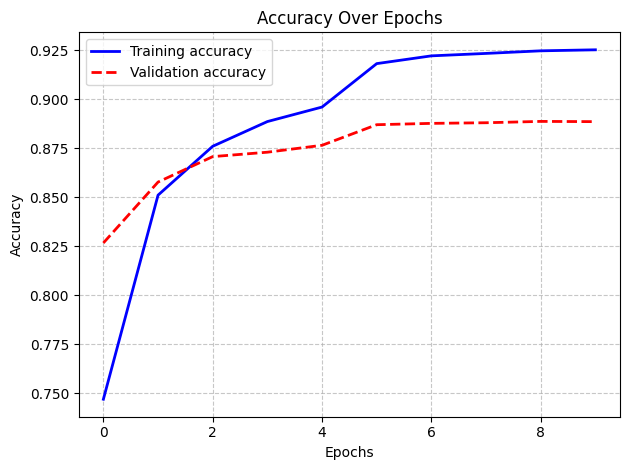

In [ ]:
model.visualize(history, "accuracy")

In [ ]:
test_loss, test_accuracy, test_recall, test_precision = model.evaluate()
print("-" * 110)
print(f"Loss: {test_loss:.2f}")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {test_precision:.2f}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8787 - loss: 0.4004 - precision: 0.9059 - recall: 0.8592
--------------------------------------------------------------------------------------------------------------
Loss: 0.36
Accuracy: 0.89
Recall: 0.87
Precision: 0.91


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


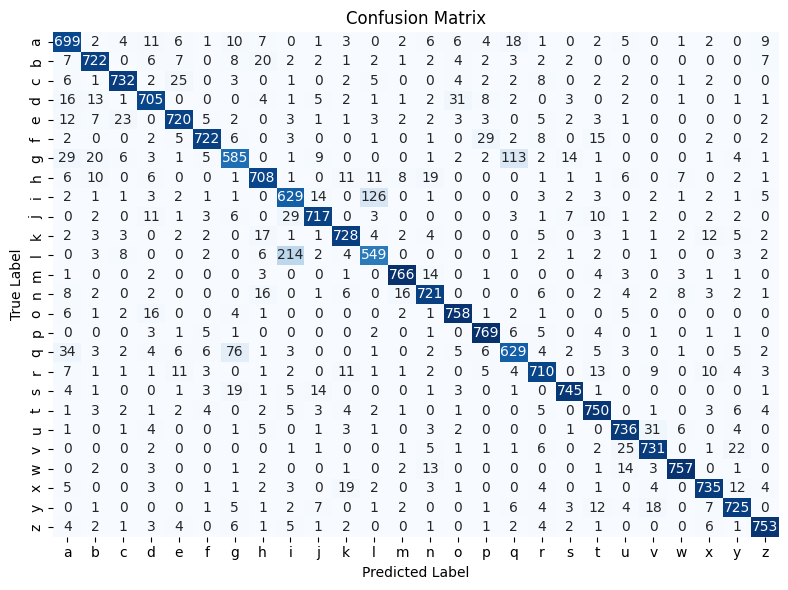

In [ ]:
model.display_confusion_matrix(classes=dataset.classes)

### **Experiment-6**

- `epochs`: 10
- `batch size`: 8
- `hidden layers`: 1
- `hidden neurons`: 256
- `hidden activations`: Sigmoid

In [ ]:
config.epochs = 10
config.batch_size = 8
config.hidden_layers = 1
config.hidden_neurons = [256]
config.hidden_activations = ["sigmoid"]

model = Model(config=config)

model.build()

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (8, 256)                    │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (8, 26)                     │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,642 (811.10 KB)

 Trainable params: 207,642 (811.10 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile()

history = model.train()

Epoch 1/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - accuracy: 0.6812 - loss: 1.1284 - precision: 0.8609 - recall: 0.5119 - val_accuracy: 0.8518 - val_loss: 0.4864 - val_precision: 0.8999 - val_recall: 0.8086 - learning_rate: 0.0010
Epoch 2/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.8681 - loss: 0.4249 - precision: 0.9089 - recall: 0.8324 - val_accuracy: 0.8827 - val_loss: 0.3855 - val_precision: 0.9136 - val_recall: 0.8562 - learning_rate: 0.0010
Epoch 3/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - accuracy: 0.8979 - loss: 0.3236 - precision: 0.9241 - recall: 0.8760 - val_accuracy: 0.8905 - val_loss: 0.3503 - val_precision: 0.9151 - val_recall: 0.8714 - learning_rate: 0.0010
Epoch 4/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - accuracy: 0.9099 - loss: 0.2759 - precision: 0.9300 - recall: 0.8929 - val_accuracy: 0.8820 - val_loss: 0.3708 - val_precision: 0.9043 - val_recall: 0.8666 - learning_rate: 0.0010
Epoch 5/10
12480/12480 ━━━━━━━━━━━━━━━━━━━━ 

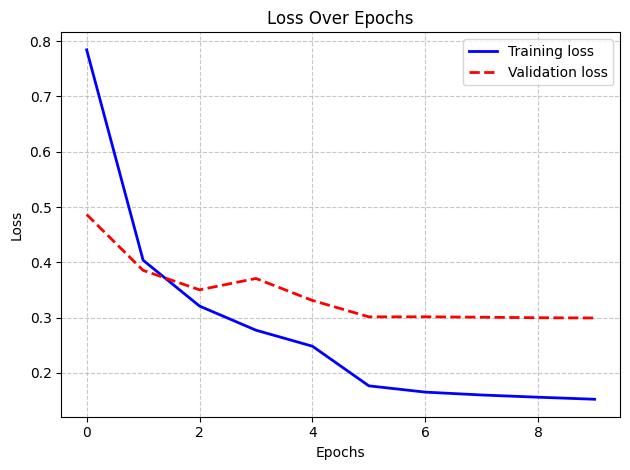

In [ ]:
model.visualize(history, "loss")

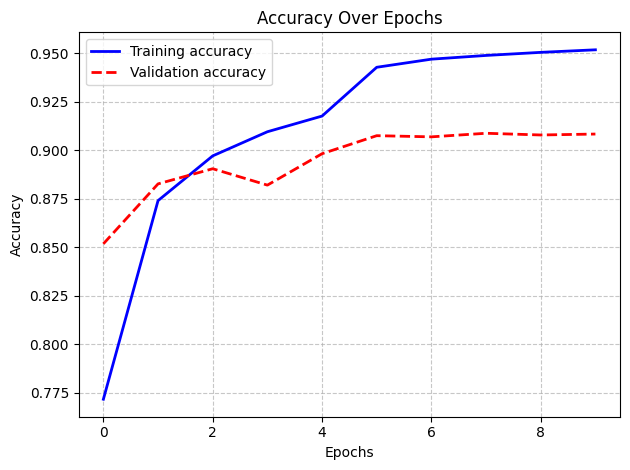

In [ ]:
model.visualize(history, "accuracy")

In [ ]:
test_loss, test_accuracy, test_recall, test_precision = model.evaluate()
print("-" * 110)
print(f"Loss: {test_loss:.2f}")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {test_precision:.2f}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8983 - loss: 0.3438 - precision: 0.9140 - recall: 0.8877
--------------------------------------------------------------------------------------------------------------
Loss: 0.31
Accuracy: 0.91
Recall: 0.90
Precision: 0.92


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


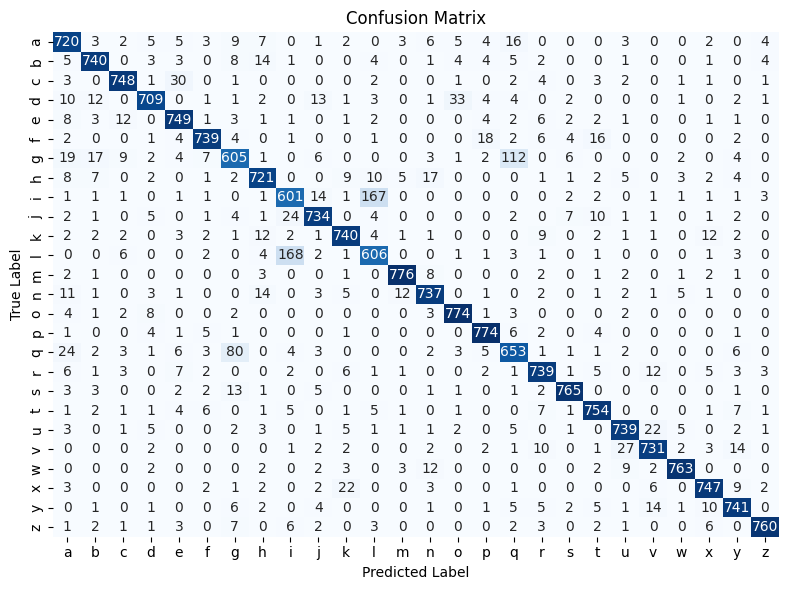

In [ ]:
model.display_confusion_matrix(classes=dataset.classes)

### **Experiment-7**

- `epochs`: 10
- `batch size`: 128
- `hidden layers`: 1
- `hidden neurons`: 512
- `hidden activations`: Tanh

In [ ]:
config.epochs = 10
config.batch_size = 128
config.hidden_layers = 1
config.hidden_neurons = [512]
config.hidden_activations = ["tanh"]

model = Model(config=config)

model.build()

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (128, 512)                  │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (128, 26)                   │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 415,258 (1.58 MB)

 Trainable params: 415,258 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile()

history = model.train()

Epoch 1/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6525 - loss: 1.2135 - precision: 0.8312 - recall: 0.5038 - val_accuracy: 0.8170 - val_loss: 0.6324 - val_precision: 0.8915 - val_recall: 0.7433 - learning_rate: 0.0010
Epoch 2/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8405 - loss: 0.5433 - precision: 0.9039 - recall: 0.7841 - val_accuracy: 0.8690 - val_loss: 0.4503 - val_precision: 0.9116 - val_recall: 0.8292 - learning_rate: 0.0010
Epoch 3/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8834 - loss: 0.3870 - precision: 0.9213 - recall: 0.8500 - val_accuracy: 0.8869 - val_loss: 0.3743 - val_precision: 0.9176 - val_recall: 0.8614 - learning_rate: 0.0010
Epoch 4/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9044 - loss: 0.3061 - precision: 0.9304 - recall: 0.8791 - val_accuracy: 0.8944 - val_loss: 0.3440 - val_precision: 0.9202 - val_recall: 0.8718 - learning_rate: 0.0010
Epoch 5/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - 

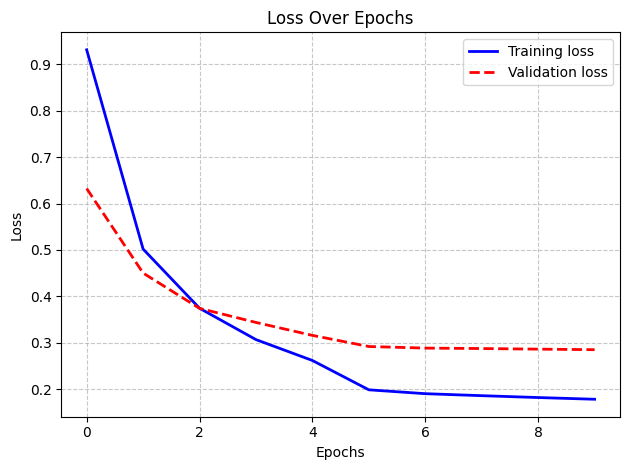

In [ ]:
model.visualize(history, "loss")

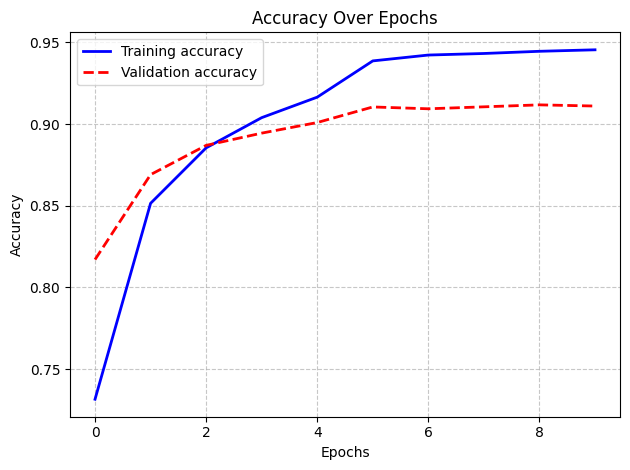

In [ ]:
model.visualize(history, "accuracy")

In [ ]:
test_loss, test_accuracy, test_recall, test_precision = model.evaluate()
print("-" * 110)
print(f"Loss: {test_loss:.2f}")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {test_precision:.2f}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9009 - loss: 0.3270 - precision: 0.9209 - recall: 0.8840
--------------------------------------------------------------------------------------------------------------
Loss: 0.29
Accuracy: 0.91
Recall: 0.90
Precision: 0.93


650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


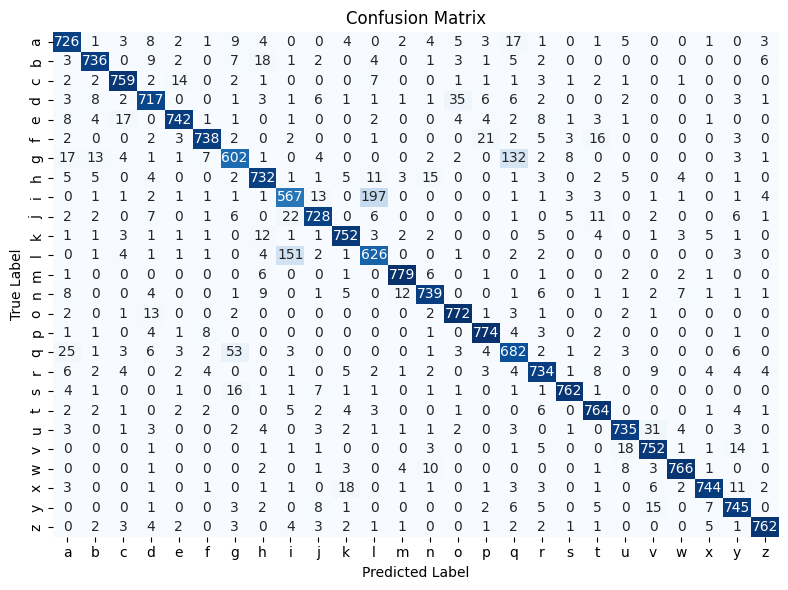

In [ ]:
model.display_confusion_matrix(classes=dataset.classes)

### **Experiment-8**

- `epochs`: 10
- `batch size`: 128
- `hidden layers`: 2
- `hidden neurons`: 512, 512
- `hidden activations`: Tanh

In [ ]:
config.epochs = 10
config.batch_size = 128
config.hidden_layers = 2
config.hidden_neurons = [512, 512]
config.hidden_activations = ["tanh", "tanh"]

model = Model(config=config)

model.build()

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (128, 512)                  │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (128, 512)                  │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (128, 26)                   │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 677,914 (2.59 MB)

 Trainable params: 677,914 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile()

history = model.train()

Epoch 1/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.6799 - loss: 1.0954 - precision: 0.8264 - recall: 0.5659 - val_accuracy: 0.8608 - val_loss: 0.4620 - val_precision: 0.9067 - val_recall: 0.8196 - learning_rate: 0.0010
Epoch 2/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8739 - loss: 0.4059 - precision: 0.9118 - recall: 0.8415 - val_accuracy: 0.8741 - val_loss: 0.3893 - val_precision: 0.9053 - val_recall: 0.8517 - learning_rate: 0.0010
Epoch 3/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9030 - loss: 0.2999 - precision: 0.9261 - recall: 0.8818 - val_accuracy: 0.8927 - val_loss: 0.3337 - val_precision: 0.9173 - val_recall: 0.8734 - learning_rate: 0.0010
Epoch 4/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9197 - loss: 0.2426 - precision: 0.9360 - recall: 0.9047 - val_accuracy: 0.9011 - val_loss: 0.3118 - val_precision: 0.9192 - val_recall: 0.8875 - learning_rate: 0.0010
Epoch 5/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - 

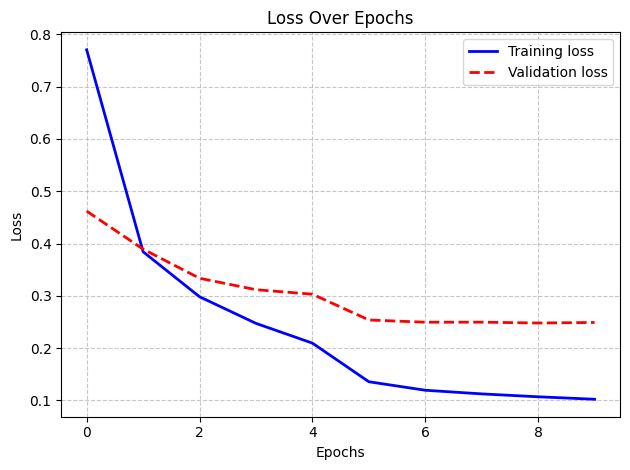

In [ ]:
model.visualize(history, "loss")

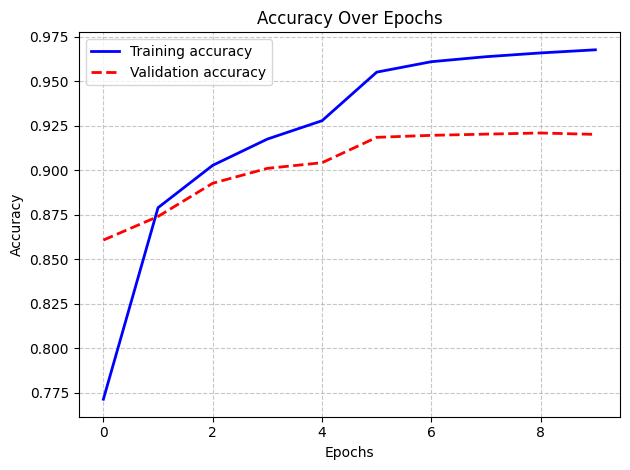

In [ ]:
model.visualize(history, "accuracy")

In [ ]:
test_loss, test_accuracy, test_recall, test_precision = model.evaluate()
print("-" * 110)
print(f"Loss: {test_loss:.2f}")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {test_precision:.2f}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9127 - loss: 0.2780 - precision: 0.9263 - recall: 0.9019
--------------------------------------------------------------------------------------------------------------
Loss: 0.26
Accuracy: 0.92
Recall: 0.91
Precision: 0.93


650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


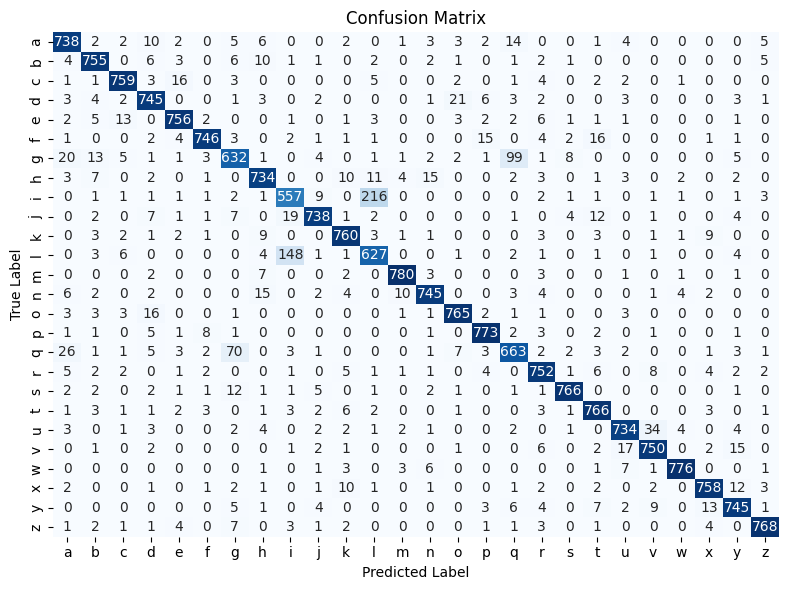

In [ ]:
model.display_confusion_matrix(classes=dataset.classes)